In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Concatenate, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

######## SEED setzen
import random
# Random Seed setzen:
random.seed(49)
np.random.seed(49)
SEED = 49

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

2.10.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### SINGLE LABEL Experiment mit LSTM

In [3]:
single_lable = pd.read_csv('Preprocess-Data/preprocessed_single_label.csv')
single_lable.head()

,Unnamed: 0,Titel,Lyric,Artist,Genres
0,1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,Axé
1,1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,Axé
2,2586,Loved You Right Away,moment saw minute met wonderful feeling never ...,Carlinhos Brown,Axé
3,2627,Goodbye Hello,alone time feel blues way inventions invention...,Carlinhos Brown,Axé
4,2640,Mess In The Freeway,wanna tell wonderful things wanna tell interes...,Carlinhos Brown,Axé


In [4]:
single_lable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42760 entries, 0 to 42759
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42760 non-null  int64 
 1   Titel       42758 non-null  object
 2   Lyric       42758 non-null  object
 3   Artist      42760 non-null  object
 4   Genres      42760 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [5]:
# Entfernen der nicht benötigten Spalte
single_data = single_lable.drop(columns=['Unnamed: 0'])

single_data['Lyric'] = single_data['Lyric'].astype(str)
# Umwandlung aller Texte in Kleinbuchstaben (falls noch nicht geschehen)
single_data['Lyric'] = single_data['Lyric'].str.lower()

In [6]:
# Identifizieren der meist vorkommenden Genres
top_genres = single_data['Genres'].value_counts().nlargest(5).index
# genres = ['Gospel/Religioso', 'Jazz', 'Pop/Rock', 'Rock', 'Pop', 'Rap', 'Punk Rock']
genres = ['Gospel/Religioso', 'Blues', 'Heavy Metal', 'Rap', 'Jazz'] 
filtered_data = single_data[single_data['Genres'].isin(genres)]

filtered_data.head()

,Titel,Lyric,Artist,Genres
7,At Last,last love come along lonely days life like son...,Etta James,Blues
8,I'd Rather Go Blind,something told saw talking something deep soul...,Etta James,Blues
9,Stormy Weather,dont know theres sun sky stormy weather since ...,Etta James,Blues
10,W-O-M-A-N,talkin man always ready go comes movin babe yo...,Etta James,Blues
11,Oh Happy Day,oh happy day oh happy day oh happy day oh happ...,Etta James,Blues


In [7]:
# Feature-Extraktion
filtered_data['word_count'] = filtered_data['Lyric'].apply(lambda x: len(x.split()))
filtered_data['avg_word_length'] = filtered_data['Lyric'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
filtered_data['unique_words'] = filtered_data['Lyric'].apply(lambda x: len(set(x.split())))

C:\Users\Leo\AppData\Local\Temp\ipykernel_4896\215376383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['word_count'] = filtered_data['Lyric'].apply(lambda x: len(x.split()))
C:\Users\Leo\AppData\Local\Temp\ipykernel_4896\215376383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_word_length'] = filtered_data['Lyric'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
C:\Users\Leo\AppData\Local\Temp\ipykernel_4896\215376383.py:

In [8]:
# Vorbereitung der Labels
encoder = LabelEncoder()
filtered_data['Genres'] = encoder.fit_transform(filtered_data['Genres'])
labels = to_categorical(filtered_data['Genres'])

C:\Users\Leo\AppData\Local\Temp\ipykernel_4896\3848746753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Genres'] = encoder.fit_transform(filtered_data['Genres'])


In [9]:
# # Aufteilen der Daten in Trainings- und Testsets
# train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=SEED)

# Aufteilen der Daten in Trainings-, Validierungs- und Testsets
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=SEED)  # 0.25 * 0.8 = 0.2

In [10]:
print('complete:',len(filtered_data))
print('train size:',len(train_data))
print('val size:', len(val_data))
print('test size:',len(test_data))

complete: 10256
train size: 6153
val size: 2051
test size: 2052


In [11]:
# Tokenizer vorbereiten und Texte zu Sequenzen umwandeln
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Lyric'])
train_sequences = tokenizer.texts_to_sequences(train_data['Lyric'])
val_sequences = tokenizer.texts_to_sequences(val_data['Lyric'])
test_sequences = tokenizer.texts_to_sequences(test_data['Lyric'])

In [12]:
print(train_sequences[0])

[122, 2211, 8318, 13281, 72, 1520, 2297, 2147, 16292, 10053, 862, 316, 361, 295, 251, 21703, 3487, 13282, 958, 1520, 2297, 2147, 16292]


In [13]:
# Padding der Sequenzen, damit sie die gleiche Länge haben
max_length = max(train_data['word_count'].max(), val_data['word_count'].max(), test_data['word_count'].max())
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [14]:
# Feature-Matrix
train_features = train_data[['word_count', 'avg_word_length', 'unique_words']].values
val_features = val_data[['word_count', 'avg_word_length', 'unique_words']].values
test_features = test_data[['word_count', 'avg_word_length', 'unique_words']].values

In [15]:
from tensorflow.keras.utils import to_categorical

# Kodiere die Labels in One-Hot-Format
train_labels = to_categorical(train_data['Genres'])
val_labels = to_categorical(val_data['Genres'])
test_labels = to_categorical(test_data['Genres'])

In [16]:
# # Labels kodieren
# encoder = LabelEncoder()
# encoder.fit(train_data['Genres'])
# train_labels = encoder.transform(train_data['Genres'])
# test_labels = encoder.transform(test_data['Genres'])

In [17]:
# # Labels zu Kategorien konvertieren
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

In [18]:
# LSTM Modell
input_text = Input(shape=(max_length,))
input_features = Input(shape=(3,))
embedded_text = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_text)
lstm_out = LSTM(100)(embedded_text)
concatenated = Concatenate()([lstm_out, input_features])
output = Dense(units=labels.shape[1], activation='softmax')(concatenated)
model = Model(inputs=[input_text, input_features], outputs=output)

In [19]:
# # LSTM-Modell definieren
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(units=train_labels.shape[1], activation='softmax'))

In [20]:
# Kompilieren 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [21]:
# Modell kompilieren
# EarlyStopping Callback definieren
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Modell trainieren
# history = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels), verbose=1, callbacks=[early_stopping])
history = model.fit([train_padded, train_features], train_labels, 
          validation_data=([val_padded, val_features], val_labels), 
          epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
193/193 [==============================] - 23s 94ms/step - loss: 3.5454 - accuracy: 0.4739 - val_loss: 1.8537 - val_accuracy: 0.5441
Epoch 2/10
193/193 [==============================] - 18s 91ms/step - loss: 1.5263 - accuracy: 0.5614 - val_loss: 1.3600 - val_accuracy: 0.5909
Epoch 3/10
193/193 [==============================] - 16s 85ms/step - loss: 1.0033 - accuracy: 0.6847 - val_loss: 1.0491 - val_accuracy: 0.6982
Epoch 4/10
193/193 [==============================] - 17s 85ms/step - loss: 0.6720 - accuracy: 0.7947 - val_loss: 0.7725 - val_accuracy: 0.7645
Epoch 5/10
193/193 [==============================] - 16s 85ms/step - loss: 0.3686 - accuracy: 0.8861 - val_loss: 0.7197 - val_accuracy: 0.7928
Epoch 6/10
193/193 [==============================] - 17s 87ms/step - loss: 0.2375 - accuracy: 0.9265 - val_loss: 0.7035 - val_accuracy: 0.7996
Epoch 7/10
193/193 [==============================] - 17s 88ms/step - loss: 0.1638 - accuracy: 0.9504 - val_loss: 0.7089 - val_accuracy:

In [23]:
# Helper function to plot the history of a model
def plot_history(history):
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()
    # summarize history for loss, start from second epoch, cause the first is always too high
    plt.plot(epochs[1:], history.history['loss'][1:], 'o-', label='Training loss')
    plt.plot(epochs[1:], history.history['val_loss'][1:], 'o-', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs[1:])  # Adjust x-axis to start from second epoch
    plt.legend(loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


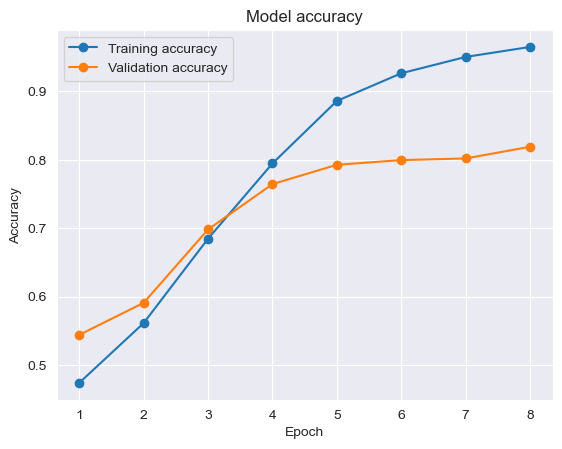

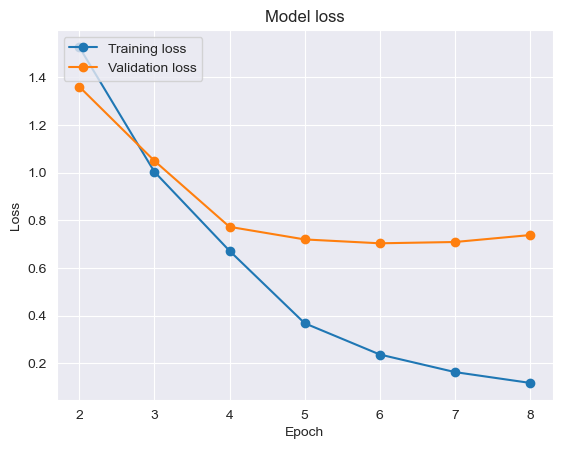

In [24]:
plot_history(history)

In [25]:
# loss, accuracy = model.evaluate(test_padded, test_labels, verbose=1)
test_loss, test_accuracy = model.evaluate([test_padded, test_features], test_labels)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

65/65 [==============================] - 2s 36ms/step - loss: 0.7087 - accuracy: 0.8182
Test Accuracy: 81.82%
Test Loss: 0.7087


In [26]:
# predictions = model.predict(test_padded)
# predicted_labels = predictions.argmax(axis=1)  # Umwandlung der One-Hot-Encoded-Vorhersagen in Label-Indizes

# Vorhersagen machen
predictions = model.predict([test_padded, test_features])
predicted_labels = predictions.argmax(axis=1)

# Echte Labels für Vergleich
true_labels = test_data['Genres'].values

65/65 [==============================] - 3s 34ms/step


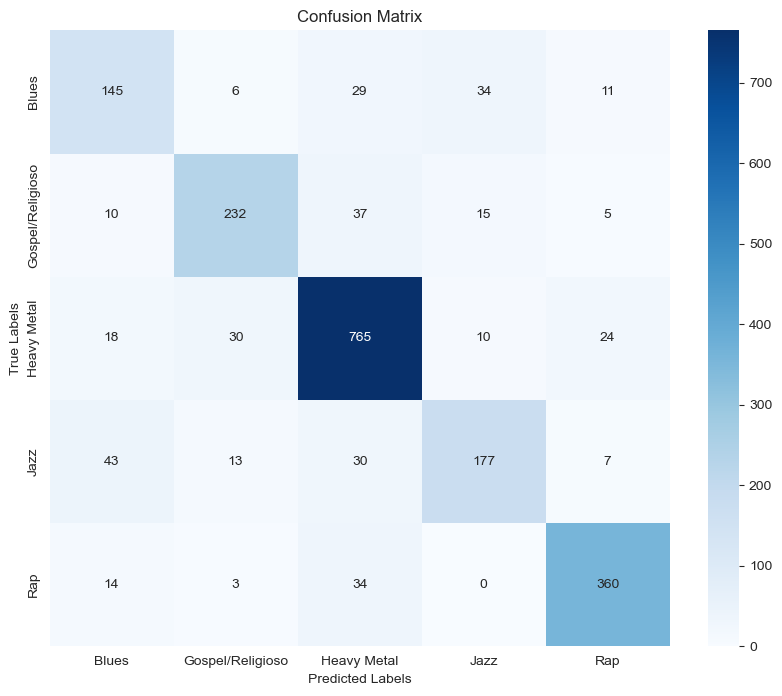

In [27]:

# true_labels = test_labels.argmax(axis=1)  # Umwandlung der tatsächlichen One-Hot-Encoded-Labels in Label-Indizes
cm = confusion_matrix(true_labels, predicted_labels)

# Konfusionsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
report = classification_report(true_labels, predicted_labels, target_names=encoder.classes_)
print(report)

                  precision    recall  f1-score   support

           Blues       0.63      0.64      0.64       225
Gospel/Religioso       0.82      0.78      0.80       299
     Heavy Metal       0.85      0.90      0.88       847
            Jazz       0.75      0.66      0.70       270
             Rap       0.88      0.88      0.88       411

        accuracy                           0.82      2052
       macro avg       0.79      0.77      0.78      2052
    weighted avg       0.82      0.82      0.82      2052


In [29]:
# sample_texts = test_data['Lyric'].iloc[:10]  # Auswahl einiger Beispielsongtexte
# sample_labels = test_labels[:10]
# sample_predictions = model.predict(pad_sequences(tokenizer.texts_to_sequences(sample_texts), maxlen=max_length))
# 
# for i, text in enumerate(sample_texts):
#     true_label = encoder.classes_[sample_labels[i].argmax()]
#     predicted_label = encoder.classes_[sample_predictions[i].argmax()]
#     print(f"Lyric: {text[:50]}... \nTrue Genre: {true_label}, Predicted Genre: {predicted_label}\n")

# Optional: Ausgabe einiger Vorhersagen
for i in range(10):  # Anzeigen von 10 Vorhersagen
    print(f"Lyric: {test_data['Lyric'].iloc[i][:50]}...")  # Zeige ersten 50 Zeichen des Lyrics
    print(f"Predicted Genre: {encoder.inverse_transform([predicted_labels[i]])[0]}, True Genre: {encoder.inverse_transform([true_labels[i]])[0]}\n")

Lyric: verse qtip brother brother brother lucien youre li...
Predicted Genre: Rap, True Genre: Rap

Lyric: ridenhour shocklee sadler bammm say goddamn dope j...
Predicted Genre: Rap, True Genre: Rap

Lyric: intro word yknowhutimsayin gotta globe world mail ...
Predicted Genre: Rap, True Genre: Rap

Lyric: coup dètat military force hundreds dead disappear ...
Predicted Genre: Heavy Metal, True Genre: Heavy Metal

Lyric: oh long long may december days grow short reach se...
Predicted Genre: Jazz, True Genre: Jazz

Lyric: moon river wider mile im crossing style day oh dre...
Predicted Genre: Jazz, True Genre: Jazz

Lyric: holy uncreated one beauty fills skies glory majest...
Predicted Genre: Gospel/Religioso, True Genre: Gospel/Religioso

Lyric: dont know love til youve learned meaning blues you...
Predicted Genre: Jazz, True Genre: Jazz

Lyric: verse one soon la stepped floor people started hol...
Predicted Genre: Rap, True Genre: Rap

Lyric: ah yeah wanna send one jeep lovers worldwide 